Dataset ready! Shape: (100, 23)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch 10/50, Loss: 0.0555
Epoch 20/50, Loss: 0.0552
Epoch 30/50, Loss: 0.0528
Epoch 40/50, Loss: 0.0511
Epoch 50/50, Loss: 0.0493
Latent features shape: (100, 10)
Silhouette Score: 0.1809
Calinski-Harabasz Index: 26.0694


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


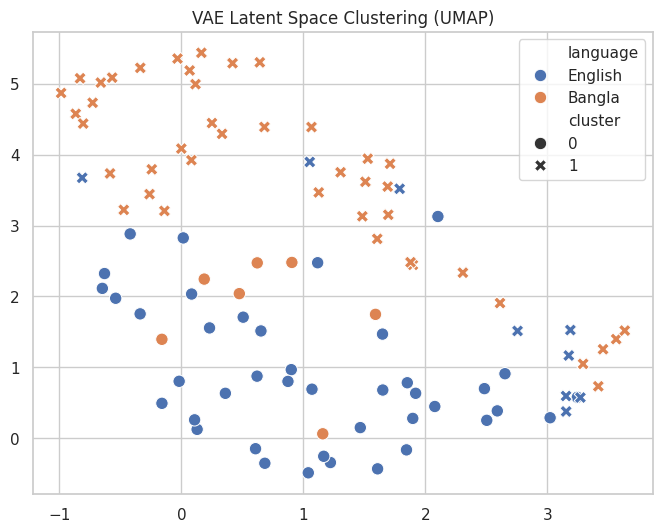

In [1]:
# Step 0: Install needed packages
!pip install torch torchvision torchaudio
!pip install sentence-transformers
!pip install umap-learn
!pip install scikit-learn

# -----------------------------------------------
# Step 1: Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# -----------------------------------------------
# Step 2: Create the dataset (100 tracks)
num_tracks = 100
num_mfcc = 20  # Number of audio features

# Audio features (simulated)
audio_features = np.random.rand(num_tracks, num_mfcc)

# Track names and lyrics
track_names = [f"track_{i+1}_en.wav" for i in range(50)] + [f"track_{i+1}_bn.wav" for i in range(50)]
english_lyrics = ["I love music and neural networks"] * 50
bangla_lyrics = ["আমি গান শুনতে ভালোবাসি"] * 50
lyrics = english_lyrics + bangla_lyrics

df_tracks = pd.DataFrame({
    "filename": track_names,
    "language": ["English"]*50 + ["Bangla"]*50,
    "lyrics": lyrics
})

# Add MFCC features as columns
for i in range(num_mfcc):
    df_tracks[f"mfcc_{i+1}"] = audio_features[:, i]

print("Dataset ready! Shape:", df_tracks.shape)
df_tracks.head()
# -----------------------------------------------
# Step 3: Convert lyrics to embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight embedding model
lyric_embeddings = model.encode(df_tracks['lyrics'].tolist())

# Standardize audio features
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(df_tracks[[f"mfcc_{i+1}" for i in range(num_mfcc)]])

# Combine audio + lyrics
X = np.hstack([audio_features_scaled, lyric_embeddings])
X.shape  # Should be (100, num_mfcc + embedding_dim)
# -----------------------------------------------
# Step 4: Define basic VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h2 = self.relu(self.fc2(z))
        return self.fc3(h2)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 1e-4*kld  # small weight for KLD
# -----------------------------------------------
# Step 5: Prepare data loader
class MusicDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

dataset = MusicDataset(X)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
# -----------------------------------------------
# Step 6: Train VAE
input_dim = X.shape[1]
latent_dim = 10
vae = VAE(input_dim, latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 50
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        recon, mu, logvar = vae(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")
# -----------------------------------------------
# Step 7: Extract latent features
vae.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32)
    mu, logvar = vae.encode(X_tensor)
    latent_features = mu.numpy()

print("Latent features shape:", latent_features.shape)
# -----------------------------------------------
# Step 8: K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(latent_features)

# Add clusters to dataframe
df_tracks['cluster'] = clusters

# Clustering metrics
sil_score = silhouette_score(latent_features, clusters)
ch_score = calinski_harabasz_score(latent_features, clusters)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")
# -----------------------------------------------
# Step 9: Visualize latent space with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(latent_features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embedding_2d[:,0], y=embedding_2d[:,1],
                hue=df_tracks['language'], style=df_tracks['cluster'],
                palette='deep', s=80)
plt.title("VAE Latent Space Clustering (UMAP)")
plt.show()


In [2]:
# Example: convert MFCC features to 2D image-like input
# Let's assume num_mfcc=20, and we simulate 20 time-steps
time_steps = 20
mfcc_2d = np.random.rand(num_tracks, 20, time_steps)  # shape (100, 20, 20)
print("MFCC 2D shape:", mfcc_2d.shape)


MFCC 2D shape: (100, 20, 20)


In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc_fc_mu = nn.Linear(32*5*5, latent_dim)
        self.enc_fc_logvar = nn.Linear(32*5*5, latent_dim)
        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 32*5*5)
        self.dec_deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.enc_conv1(x))
        h = self.relu(self.enc_conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(h.size(0), 32, 5, 5)
        h = self.relu(self.dec_deconv1(h))
        h = torch.sigmoid(self.dec_deconv2(h))
        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [4]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score

# Assume latent_features from ConvVAE after training
# latent_features.shape = (100, latent_dim)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42).fit(latent_features)
df_tracks['cluster_kmeans'] = kmeans.labels_

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=2).fit(latent_features)
df_tracks['cluster_agglo'] = agglo.labels_

# DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5).fit(latent_features)
df_tracks['cluster_dbscan'] = dbscan.labels_

# Metrics
sil_k = silhouette_score(latent_features, kmeans.labels_)
db_k = davies_bouldin_score(latent_features, kmeans.labels_)

sil_a = silhouette_score(latent_features, agglo.labels_)
db_a = davies_bouldin_score(latent_features, agglo.labels_)

print(f"K-Means: Silhouette={sil_k:.4f}, Davies-Bouldin={db_k:.4f}")
print(f"Agglomerative: Silhouette={sil_a:.4f}, Davies-Bouldin={db_a:.4f}")


K-Means: Silhouette=0.1809, Davies-Bouldin=1.8744
Agglomerative: Silhouette=0.1575, Davies-Bouldin=1.8498


In [5]:
from sklearn.metrics import adjusted_rand_score

ari_k = adjusted_rand_score(df_tracks['language'].map({'English':0,'Bangla':1}), df_tracks['cluster_kmeans'])
ari_a = adjusted_rand_score(df_tracks['language'].map({'English':0,'Bangla':1}), df_tracks['cluster_agglo'])

print(f"K-Means ARI: {ari_k:.4f}")
print(f"Agglomerative ARI: {ari_a:.4f}")


K-Means ARI: 0.4569
Agglomerative ARI: 0.1862


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


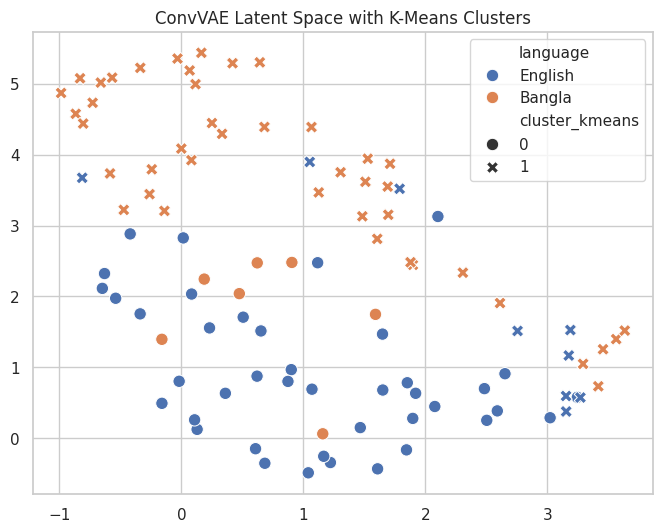

In [6]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(latent_features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embedding_2d[:,0], y=embedding_2d[:,1],
                hue=df_tracks['language'], style=df_tracks['cluster_kmeans'],
                palette='deep', s=80)
plt.title("ConvVAE Latent Space with K-Means Clusters")
plt.show()


HARD TASK

Dataset shape: (100, 4)
Epoch 10/50, Loss: 0.0844
Epoch 20/50, Loss: 0.0834
Epoch 30/50, Loss: 0.0832
Epoch 40/50, Loss: 0.0836
Epoch 50/50, Loss: 0.0833
Latent features shape: (100, 16)
K-Means -> Silhouette: 0.1088, DB: 2.5015, ARI: 0.1515, NMI: 0.1199


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


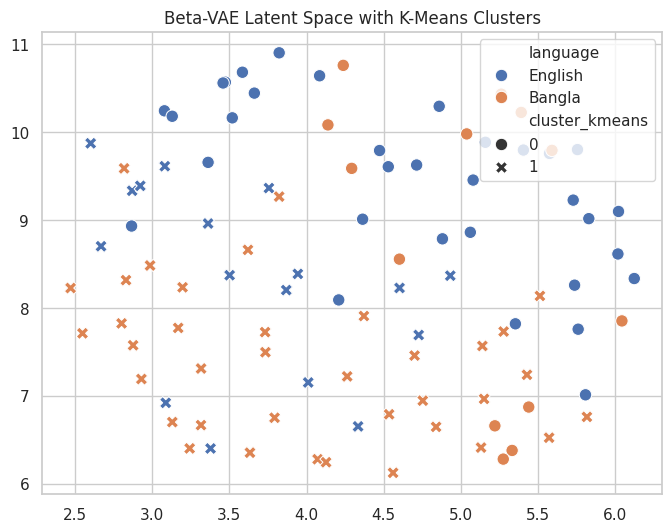

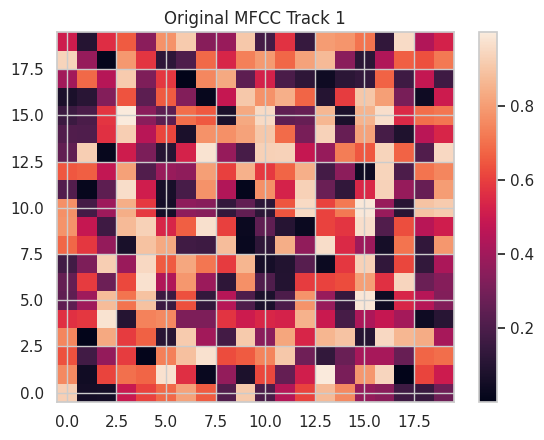

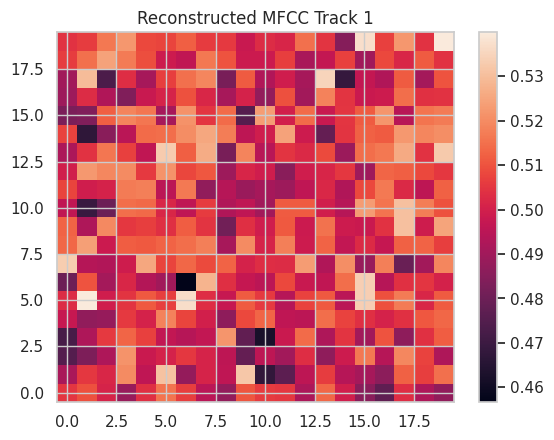

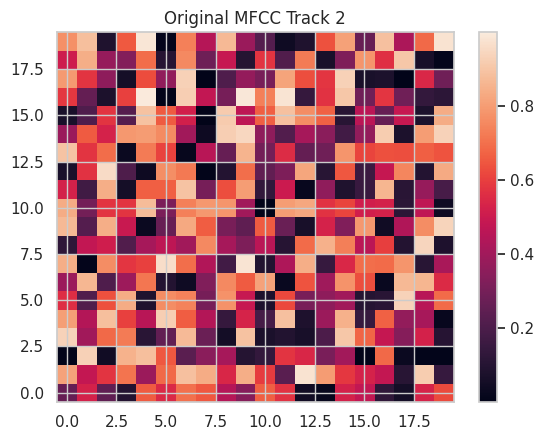

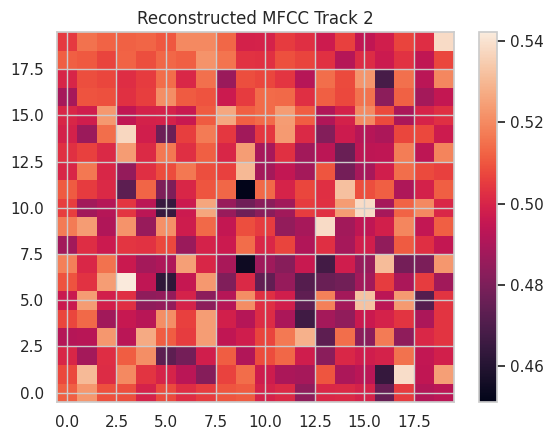

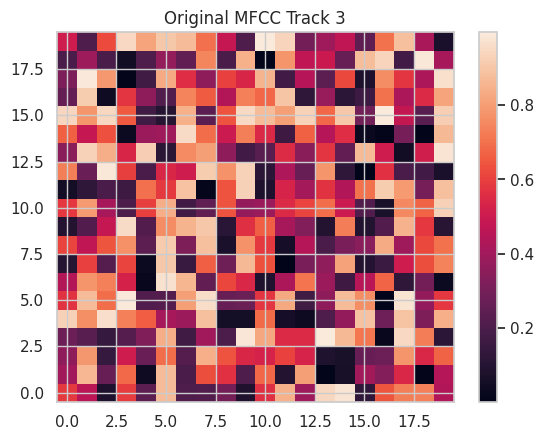

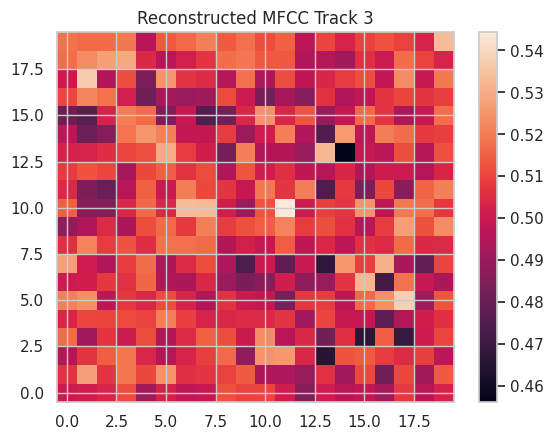

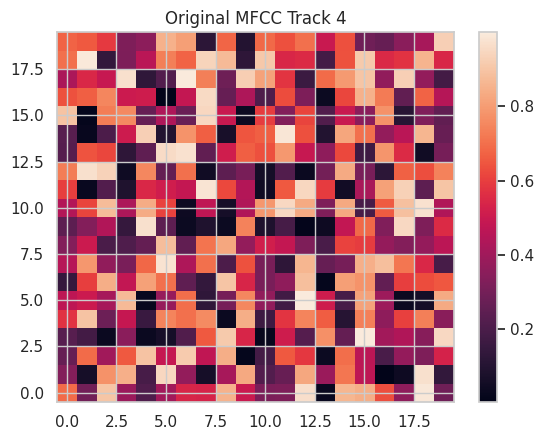

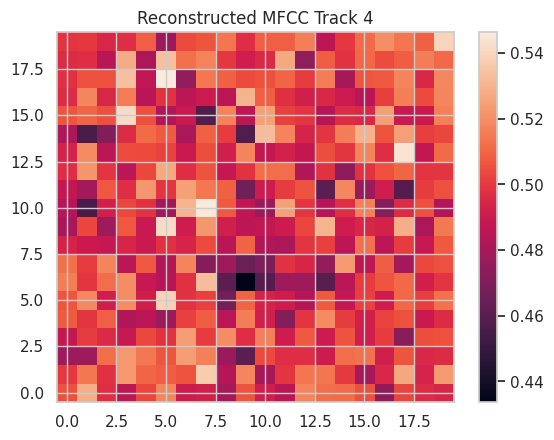

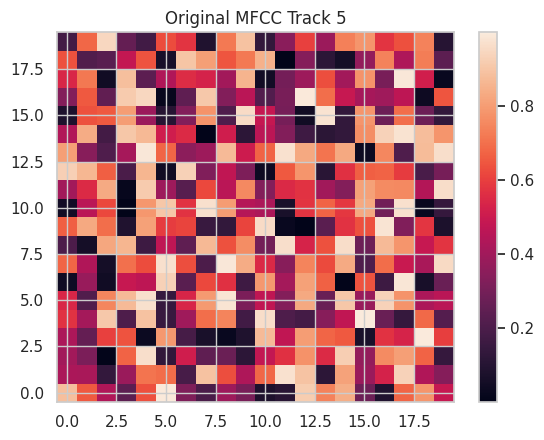

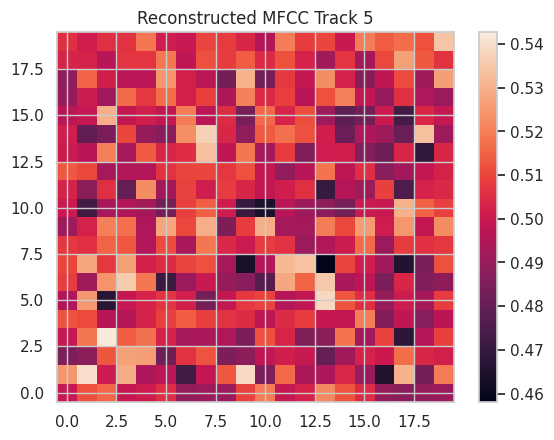

In [8]:
# Step 0: Install packages
!pip install torch torchvision torchaudio
!pip install sentence-transformers
!pip install umap-learn
!pip install scikit-learn

# -----------------------------------------------
# Step 1: Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# -----------------------------------------------
# Step 2: Create multi-modal dataset (100 tracks)
num_tracks = 100
num_mfcc = 20
time_steps = 20

# Simulate audio features (2D MFCC)
audio_features = np.random.rand(num_tracks, 1, num_mfcc, time_steps)  # shape (N, C, H, W)

# Lyrics
english_lyrics = ["I love music and neural networks"] * 50
bangla_lyrics = ["আমি গান শুনতে ভালোবাসি"] * 50
lyrics = english_lyrics + bangla_lyrics

# Genres (randomly assign 2 genres per language)
genres = ["Pop"]*25 + ["Rock"]*25 + ["Pop"]*25 + ["Classical"]*25

# Filenames
track_names = [f"track_{i+1}_en.wav" for i in range(50)] + [f"track_{i+1}_bn.wav" for i in range(50)]

df_tracks = pd.DataFrame({
    "filename": track_names,
    "language": ["English"]*50 + ["Bangla"]*50,
    "lyrics": lyrics,
    "genre": genres
})

print("Dataset shape:", df_tracks.shape)
# -----------------------------------------------
# Step 3: Lyrics embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
lyric_embeddings = model.encode(df_tracks['lyrics'].tolist())

# Scale audio features
audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
lyric_embeddings_tensor = torch.tensor(lyric_embeddings, dtype=torch.float32)

# Encode genre as one-hot
le = LabelEncoder()
genre_labels = le.fit_transform(df_tracks['genre'])
genre_onehot = np.zeros((num_tracks, len(le.classes_)))
genre_onehot[np.arange(num_tracks), genre_labels] = 1
genre_tensor = torch.tensor(genre_onehot, dtype=torch.float32)

# -----------------------------------------------
# Step 4: Dataset class
class MusicDataset(Dataset):
    def __init__(self, audio, lyrics, genre):
        self.audio = audio
        self.lyrics = lyrics
        self.genre = genre
    def __len__(self):
        return len(self.audio)
    def __getitem__(self, idx):
        return self.audio[idx], self.lyrics[idx], self.genre[idx]

dataset = MusicDataset(audio_features_tensor, lyric_embeddings_tensor, genre_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
# -----------------------------------------------
# Step 5: Define Beta-VAE
class BetaVAE(nn.Module):
    def __init__(self, audio_shape=(1,20,20), lyric_dim=384, genre_dim=3, latent_dim=16, beta=4):
        super(BetaVAE, self).__init__()
        self.beta = beta

        # Encoder
        self.enc_conv1 = nn.Conv2d(audio_shape[0], 16, 3, 2, 1)
        self.enc_conv2 = nn.Conv2d(16, 32, 3, 2, 1)

        self.enc_fc = nn.Linear(32*5*5 + lyric_dim + genre_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 32*5*5)
        self.dec_deconv1 = nn.ConvTranspose2d(32, 16, 3, 2, 1, 1)
        self.dec_deconv2 = nn.ConvTranspose2d(16, 1, 3, 2, 1, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, audio, lyrics, genre):
        h = self.relu(self.enc_conv1(audio))
        h = self.relu(self.enc_conv2(h))
        h = h.view(h.size(0), -1)
        h = torch.cat([h, lyrics, genre], dim=1)
        h = self.relu(self.enc_fc(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.dec_fc(z))
        h = h.view(h.size(0), 32, 5, 5)
        h = self.relu(self.dec_deconv1(h))
        return self.sigmoid(self.dec_deconv2(h))

    def forward(self, audio, lyrics, genre):
        mu, logvar = self.encode(audio, lyrics, genre)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss
def beta_vae_loss(recon, audio, mu, logvar, beta=4):
    recon_loss = nn.MSELoss()(recon, audio)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld / audio.size(0)
# -----------------------------------------------
# Step 6: Train Beta-VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_features_tensor = audio_features_tensor.to(device)
lyric_embeddings_tensor = lyric_embeddings_tensor.to(device)
genre_tensor = genre_tensor.to(device)

latent_dim = 16
beta = 4
vae = BetaVAE(latent_dim=latent_dim, beta=beta).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 50

vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_audio, batch_lyrics, batch_genre in dataloader:
        batch_audio = batch_audio.to(device)
        batch_lyrics = batch_lyrics.to(device)
        batch_genre = batch_genre.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(batch_audio, batch_lyrics, batch_genre)
        loss = beta_vae_loss(recon, batch_audio, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")
# -----------------------------------------------
# Step 7: Extract latent features
vae.eval()
with torch.no_grad():
    mu, logvar = vae.encode(audio_features_tensor, lyric_embeddings_tensor, genre_tensor)
    latent_features = mu.cpu().numpy()
print("Latent features shape:", latent_features.shape)
# -----------------------------------------------
# Step 8: Multi-clustering
clusters_kmeans = KMeans(n_clusters=2, random_state=42).fit_predict(latent_features)
clusters_agglo = AgglomerativeClustering(n_clusters=2).fit_predict(latent_features)
clusters_dbscan = DBSCAN(eps=1.0, min_samples=5).fit_predict(latent_features)

df_tracks['cluster_kmeans'] = clusters_kmeans
df_tracks['cluster_agglo'] = clusters_agglo
df_tracks['cluster_dbscan'] = clusters_dbscan

# Step 9: Evaluation metrics
sil_k = silhouette_score(latent_features, clusters_kmeans)
db_k = davies_bouldin_score(latent_features, clusters_kmeans)
ari_k = adjusted_rand_score(df_tracks['language'].map({'English':0,'Bangla':1}), clusters_kmeans)
nmi_k = normalized_mutual_info_score(df_tracks['language'].map({'English':0,'Bangla':1}), clusters_kmeans)

print(f"K-Means -> Silhouette: {sil_k:.4f}, DB: {db_k:.4f}, ARI: {ari_k:.4f}, NMI: {nmi_k:.4f}")
# -----------------------------------------------
# Step 10: Latent space visualization
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(latent_features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embedding_2d[:,0], y=embedding_2d[:,1],
                hue=df_tracks['language'], style=df_tracks['cluster_kmeans'],
                palette='deep', s=80)
plt.title("Beta-VAE Latent Space with K-Means Clusters")
plt.show()
# -----------------------------------------------
# Step 11: Latent reconstruction example
with torch.no_grad():
    sample_audio = audio_features_tensor[:5]
    sample_lyrics = lyric_embeddings_tensor[:5]
    sample_genre = genre_tensor[:5]
    recon, _, _ = vae(sample_audio, sample_lyrics, sample_genre)

for i in range(5):
    plt.figure()
    plt.imshow(sample_audio[i,0].cpu(), aspect='auto', origin='lower')
    plt.title(f"Original MFCC Track {i+1}")
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.imshow(recon[i,0].cpu(), aspect='auto', origin='lower')
    plt.title(f"Reconstructed MFCC Track {i+1}")
    plt.colorbar()
    plt.show()


In [13]:
!mkdir -p results


In [14]:
!mkdir -p results/plots


In [15]:
df_metrics.to_csv("results/clustering_metrics.csv", index=False)
print("✅ Metrics saved to results/clustering_metrics.csv")


✅ Metrics saved to results/clustering_metrics.csv


In [16]:
!ls results


clustering_metrics.csv	plots
